In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
import vaex
from pytz import timezone


{'name': 'propulsion',
 'ninputs': 2,
 'input_index': {'D': 0, 'Vi': 1},
 'noutputs': 2,
 'output_index': {'Ii': 0, 'w': 1},
 'nstates': 5,
 'state_index': {'propeller_x[0]': 0,
  'transmission_x[0]': 1,
  'motor_I': 2,
  'motor_w': 3,
  'esc_x[0]': 4},
 'dt': 0,
 'params': {},
 'syslist': [<LinearIOSystem:propeller:['w']->['Q']>,
  <LinearIOSystem:transmission:['wi', 'Qo']->['wo', 'Qi']>,
  <LinearIOSystem:motor:['V', 'Q']->['I', 'w']>,
  <LinearIOSystem:esc:['D', 'Vi', 'Io']->['Vo', 'Ii']>],
 'syslist_index': {'propeller': 0, 'transmission': 1, 'motor': 2, 'esc': 3},
 'state_offset': [0, 1, 2, 4],
 'input_offset': [0, 1, 3, 5],
 'output_offset': [0, 1, 3, 5],
 'connect_map': array([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]]),
 'input_m

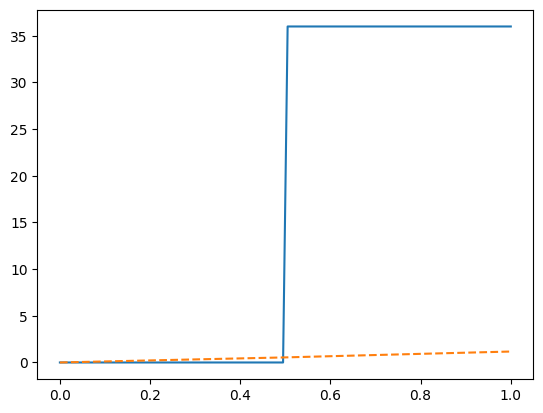

In [2]:
# Define the overall layout of the system

propulsion = ct.interconnect(
    [
        ct.rss(name="propeller", inputs=("w"), outputs=("Q")),
        ct.rss(name="transmission", inputs=("wi", "Qo"), outputs=("wo", "Qi")),
        ct.rss(name="motor", inputs=("V", "Q"), outputs=("I", "w"), states=("I", "w")),
        ct.rss(name="esc", inputs=("D", "Vi", "Io"), outputs=("Vo", "Ii")),
    ],
    name="propulsion",
    connections=[
        ["propeller.w", "transmission.wo"], ["transmission.Qo", "propeller.Q"],  # Transmission to Propeller
        ["transmission.wi", "motor.w"], ["motor.Q", "transmission.Qi"],  # Motor to Transmission
        ["motor.V", "esc.Vo"], ["esc.Io", "motor.I"],  # ESC to Motor
    ],
    inplist=["esc.D", "esc.Vi"],
    inputs=["D", "Vi"],
    outlist=["esc.Ii", "motor.w"],
    outputs=["Ii", "w"],
)
display(propulsion.__dict__)

T = np.linspace(0, 1, 100)
esc_D = np.array(
    [
        [0] * (len(T) // 2),
        [1] * (len(T) // 2),
    ]
).ravel()
esc_Vi = np.ones_like(T) * 36
U = [esc_D, esc_Vi]

T, yout = ct.input_output_response(
    propulsion, T=T, U=U, solve_ivp_kwargs={"method": "Radau"}
)

plt.plot(T, U[0] * esc_Vi)
plt.plot(T, yout[0], "--")
plt.show()


In [3]:
def add_noise(signal, target_snr_db=20):
    # Adding noise using target SNR. Ref: https://stackoverflow.com/a/53688043

    # Calculate signal power and convert to dB
    sig_avg_watts = np.mean(signal**2)
    sig_avg_db = 10 * np.log10(sig_avg_watts)

    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    # Generate an sample of white noise
    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(signal**2))

    # Noise up the original signal
    return signal + noise


'original columns:'

Index(['Battery Pack Voltage', 'Pilot Duty Cycle', 'Pilot Motor On',
       'Pilot Boat On', 'ESC Duty Cycle', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT 4 Input Current', 'MPPT 1 Duty Cycle',
       'MPPT 2 Duty Cycle', 'MPPT 3 Duty Cycle', 'MPPT 4 Duty Cycle',
       'MPPT 1 Input Power', 'MPPT 2 Input Power', 'MPPT 3 Input Power',
       'MPPT 4 Input Power', 'MPPTs Input Power', 'MPPT 1 Output Current',
       'MPPT 2 Output Current', 'MPPT 3 Output Current',
       'MPPT 4 Output Current', 'MPPTs Output Current', 'MPPT 1 Output Power',
       'MPPT 2 Output Power', 'MPPT 3 Output Power', 'MPPT 4 Output Power',
       'MPPTs Output Power', 'Battery Current', 'Battery Power',
       'ESC Input Curre

'renamed columns:'

{'Battery Pack Voltage': 'bat_v',
 'Battery Current': 'bat_i',
 'ESC Duty Cycle': 'esc_dt',
 'Motor Angular Speed': 'motor_w',
 'ESC Input Power': 'esc_pi',
 'ESC Input Current': 'esc_ii'}

'selected columns:'

Index(['bat_v', 'bat_i', 'esc_dt', 'motor_w', 'esc_pi', 'esc_ii'], dtype='object')

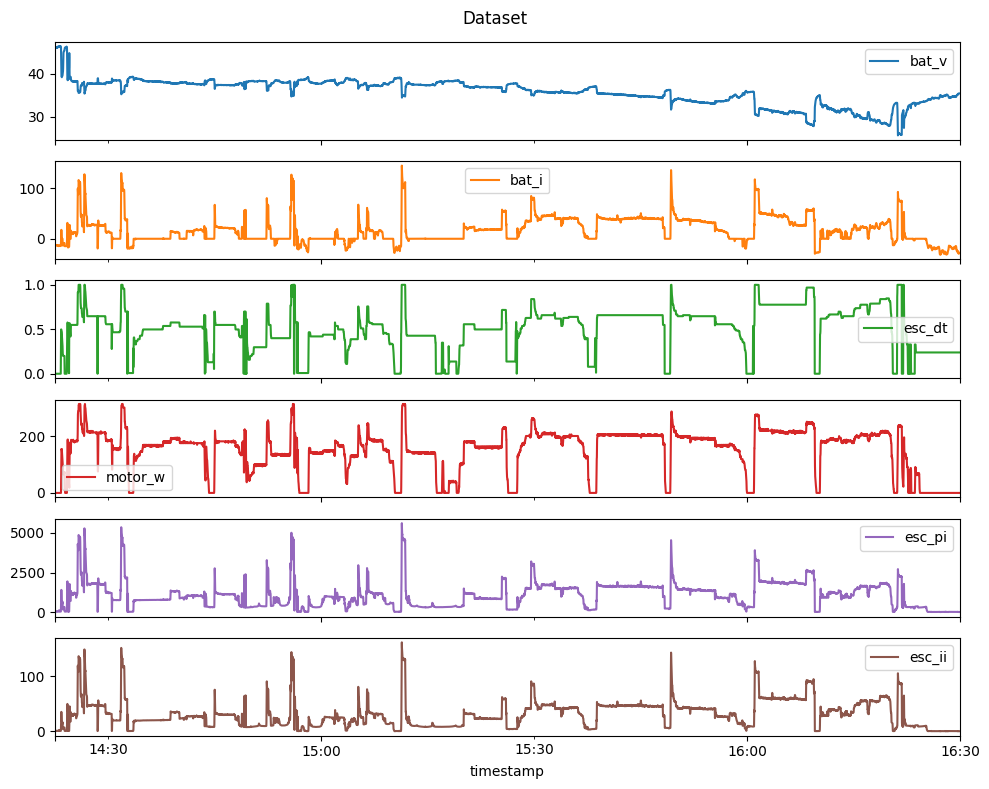

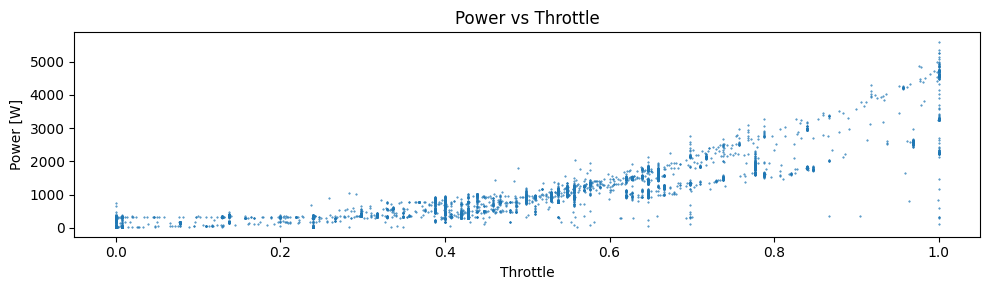

In [4]:
tzinfo = timezone("America/Sao_Paulo")

# From Revezamento
start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
# df = vaex.from_csv("../../../models/2020/boat_data_100ms.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
display('original columns:', df.columns)

renamed_columns = {
    'Battery Pack Voltage': 'bat_v',
    'Battery Current': 'bat_i',
    'ESC Duty Cycle': 'esc_dt',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_pi',
    'ESC Input Current': 'esc_ii',
}
display('renamed columns:', renamed_columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

display('selected columns:', df.columns)

df = df.interpolate(method="time")
df = df.resample('1s').ffill()

df.plot(subplots=True, figsize=(10, 8))
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.title('Power vs Throttle')
plt.xlabel('Throttle')
plt.ylabel('Power [W]')
plt.scatter(df['esc_dt'], df['esc_pi'], s=0.2)
plt.tight_layout()
plt.show()


{'name': 'propeller',
 'ninputs': 1,
 'input_index': {'w': 0},
 'noutputs': 1,
 'output_index': {'Q': 0},
 'nstates': 0,
 'state_index': {},
 'dt': 0,
 'params': {'prop_K': 0.0016229208372061088, 'prop_D': 0.2286, 'rho': 1025},
 'updfcn': None,
 'outfcn': <bound method Propeller._outputs of <class '__main__.Propeller'>>,
 '_current_params': {'prop_K': 0.0016229208372061088,
  'prop_D': 0.2286,
  'rho': 1025}}

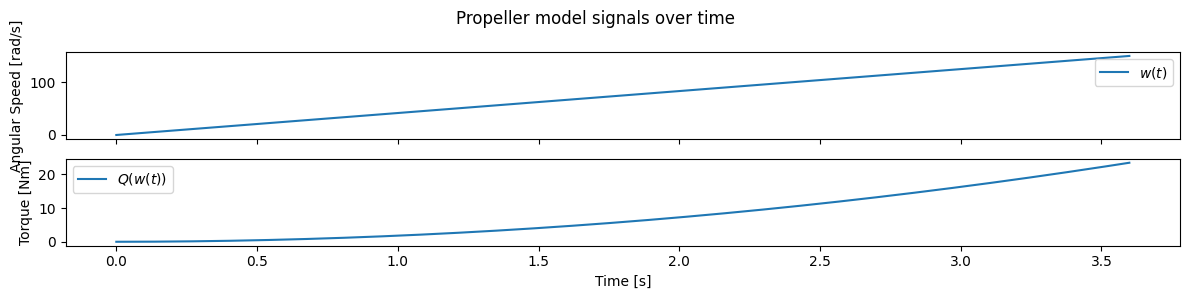

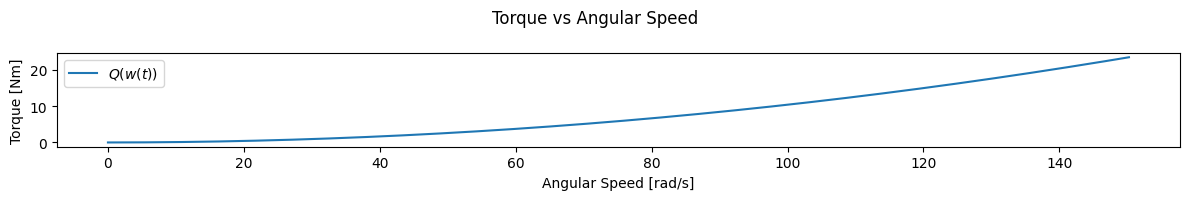

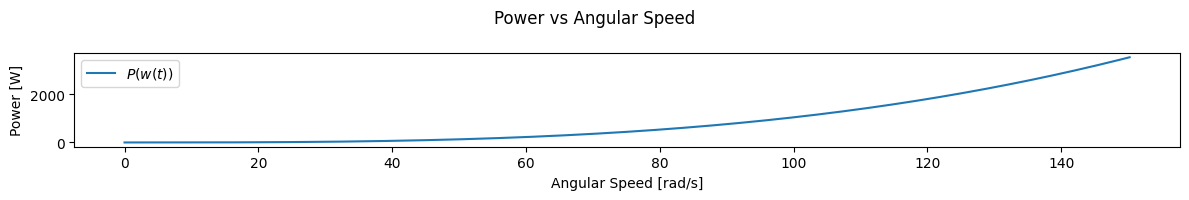

In [5]:
class Propeller:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        prop_K = params["prop_K"]
        prop_D = params["prop_D"]
        rho = params["rho"]

        # Get the inputs
        prop_w = u

        # Returns the Torque required by the Propeller
        return prop_D**5 * rho * prop_K * prop_w**2

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="propeller",
            states=None,
            inputs="w",
            outputs="Q",
            params=params,
        )

# Initial guess
trans_eff = 0.95  # Rough estimation
trans_K = 13/22  # From gear teeth count
motor_K = 0.10361811  # From performance curves
esc_eff = 0.8  # From measured data
esc_vo = (df['bat_v'] * df['esc_dt']).mean()
esc_po = df['esc_pi'].mean() * esc_eff
motor_I = esc_po / esc_vo
motor_Q = motor_K * motor_I
motor_w = df['motor_w'].mean()
prop_Q = motor_Q * trans_eff / trans_K
prop_D = 9 * 0.0254  # From the nominal propeller dimensions, it's about 70% of the measured
rho = 1025  # 20°C
prop_w = motor_w * trans_K
prop_K = (prop_Q / (prop_D**5 * rho * prop_w**2))

propeller = Propeller.build({"prop_K": prop_K, "prop_D": prop_D, "rho": rho})
display(propeller.__dict__)

T = np.arange(0, 3600) / 1000
prop_w = np.linspace(0, df['motor_w'].mean(), len(T))

res = ct.input_output_response(
    propeller, T=T, U=prop_w, solve_ivp_kwargs={"method": "Radau"}
)
res.output_labels = propeller.output_labels
res.input_labels = propeller.input_labels
res.state_labels = propeller.state_labels
outputs = res.to_pandas().set_index("time")

fig, ax = plt.subplots(2,1,figsize=(12, 3), sharex=True)
ax[0].plot(outputs["w"], label="$w(t)$")
ax[0].set_ylabel("Angular Speed [rad/s]")
ax[0].legend(loc=0)
ax[1].plot(outputs["Q"], label="$Q(w(t))$")
ax[1].set_ylabel("Torque [Nm]")
ax[1].set_xlabel("Time [s]")
ax[1].legend(loc=0)
plt.suptitle("Propeller model signals over time")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(outputs['w'], outputs['Q'], label="$Q(w(t))$")
plt.xlabel("Angular Speed [rad/s]")
plt.ylabel("Torque [Nm]")
plt.suptitle("Torque vs Angular Speed")
plt.legend(loc=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(outputs['w'], outputs['w']*outputs['Q'], label="$P(w(t))$")
plt.xlabel("Angular Speed [rad/s]")
plt.ylabel("Power [W]")
plt.suptitle("Power vs Angular Speed")
plt.legend(loc=0)
plt.tight_layout()
plt.show()

In [6]:
class Transmission:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        trans_eff = params["trans_eff"]
        trans_K = params["trans_K"]  # gear ratio as `output speed / input speed`

        # Get the inputs
        trans_wi = u[0]
        trans_Qo = u[1]

        #
        trans_wo = trans_wi * trans_K
        trans_Qi = trans_Qo * trans_K / trans_eff

        return (trans_wo, trans_Qi)

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="transmission",
            states=None,
            inputs=("wi", "Qo"),
            outputs=("wo", "Qi"),
            params=params,
        )

trans_eff = 0.95
trans_K = 13/22

transmission = Transmission.build({"trans_eff": trans_eff, "trans_K": trans_K})
display(transmission.__dict__)


{'name': 'transmission',
 'ninputs': 2,
 'input_index': {'wi': 0, 'Qo': 1},
 'noutputs': 2,
 'output_index': {'wo': 0, 'Qi': 1},
 'nstates': 0,
 'state_index': {},
 'dt': 0,
 'params': {'trans_eff': 0.95, 'trans_K': 0.5909090909090909},
 'updfcn': None,
 'outfcn': <bound method Transmission._outputs of <class '__main__.Transmission'>>,
 '_current_params': {'trans_eff': 0.95, 'trans_K': 0.5909090909090909}}

{'motor_R': 0.033,
 'motor_L': 0.001,
 'motor_B': 0.004107378189919799,
 'motor_J': 0.039200000000000006,
 'motor_K': 0.10596697039485706,
 'motor_J_load': 0}

{'name': 'motor',
 'ninputs': 2,
 'input_index': {'V': 0, 'Q': 1},
 'noutputs': 2,
 'output_index': {'I': 0, 'w': 1},
 'nstates': 2,
 'state_index': {'I': 0, 'w': 1},
 'dt': 0,
 'params': {},
 'A': array([[-3.30000000e+01, -1.05966970e+02],
        [ 2.70323904e+00, -1.04780056e-01]]),
 'B': array([[1000.        ,    0.        ],
        [   0.        ,  -25.51020408]]),
 'C': array([[1., 0.],
        [0., 1.]]),
 'D': array([[0., 0.],
        [0., 0.]])}

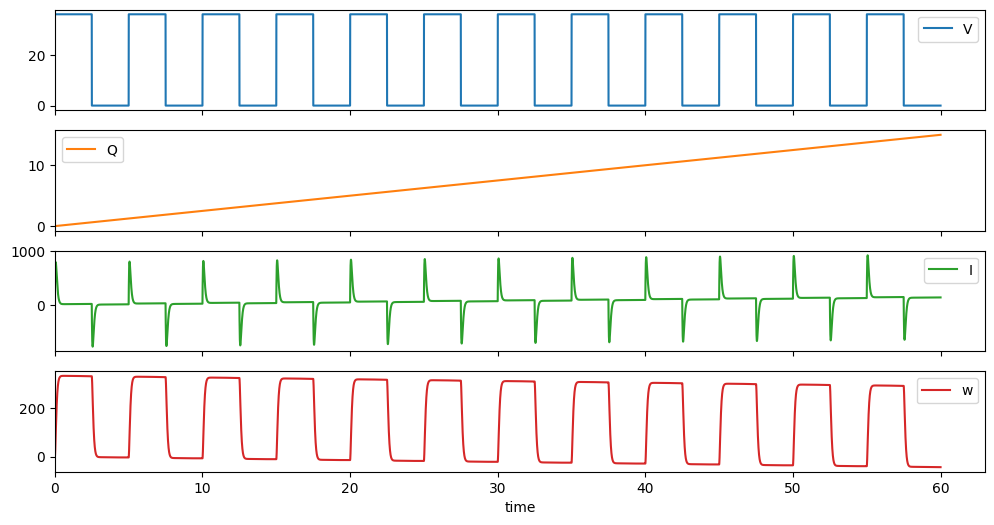

In [7]:
from scipy import signal

class Motor:
    @classmethod
    def build(cls, params: dict):
        motor_K = params["motor_K"]
        motor_R = params["motor_R"]
        motor_L = params["motor_L"]
        motor_J = params["motor_J"]
        motor_B = params["motor_B"]
        motor_J_load = params["motor_J_load"]
        motor_J_total = motor_J + motor_J_load

        # From:
        #   didt = (-motor_R*motor_i -motor_K*motor_w + motor_v) / motor_L
        #   dwdt = (motor_K*motor_i -motor_B*motor_w - motor_load_Q) / motor_J_total
        # Considering:
        #   X = [motor_I, motor_w]
        #   U = [motor_V, motor_Q]
        #   Y = [motor_I, motor_w]

        # State Transition matrix, shape 'n,n' -> '2x2'
        A = np.array(
            [
                [-motor_R / motor_L, -motor_K / motor_L],
                [+motor_K / motor_J_total, -motor_B / motor_J_total],
            ],
            dtype=np.float128,
        )

        # Input matrix, shape 'n,m' -> '2x2'
        B = np.array(
            [
                [+1 / motor_L, 0],
                [0, -1 / motor_J_total],
            ],
            dtype=np.float128,
        )

        # Output matrix, shape 'p,n' -> '3x2'
        C = np.array(
            [
                [1, 0],
                [0, 1],
            ],
            dtype=np.float128,
        )

        # Remaining matrix, shape 'p,m' -> '3x2'
        D = np.array(
            [
                [0, 0],
                [0, 0],
            ],
            dtype=np.float128,
        )

        return ct.ss(
            A,
            B,
            C,
            D,
            name="motor",
            states=("I", "w"),
            inputs=("V", "Q"),
            outputs=("I", "w"),
        )

# Initial guess
motor_V = (df['bat_v'] * df['esc_dt']).mean()
motor_R = 0.033  # Estimation
# Considering steady-state and zero load torque and solving for motor_K:
#   dwdt = (-motor_B*motor_w + motor_K*motor_i - motor_load_Q) / motor_J
#   didt = (-motor_K*motor_w - motor_R*motor_i + motor_v) / motor_L
motor_K = (motor_V - (motor_I * motor_R)) / motor_w
motor_eff = 0.8  # Averaged from the performance curves
motor_Pi = motor_V * motor_I
# Considering:
#   motor_Ple = motor_R*motor_I**2
#   motor_Plm = motor_B*motor_w**2
#   motor_Pl = motor_Ple + motor_Plm
#   motor_Po = motor_Pi * motor_eff = motor_Pi - motor_Pl
motor_B = ((motor_Pi -motor_Pi*motor_eff) - motor_R*motor_I**2)/motor_w**2
motor_L = 1e-03  # Unknown
motor_rotor_radius = (14/2)/100  # meters
motor_rotor_mass = 8  # kg
motor_J = motor_rotor_mass * motor_rotor_radius**2

params = {"motor_R": motor_R, "motor_L": motor_L, "motor_B": motor_B, "motor_J": motor_J, "motor_K": motor_K, "motor_J_load": 0}
display(params)
motor = Motor.build(params)
display(motor.__dict__)

Tend = 60
freq = int(10e3)
T = np.linspace(0, Tend, freq*5)
motor_V = np.ones_like(T) * 36  # Input voltage
motor_Q_load = np.linspace(0, 15, len(T))  # Load torque
D = 0.5  # Duty-cycle
motor_V = (signal.square(2 * np.pi * freq * T, D) + 1) * 0.5 * 36

res = ct.forced_response(motor, T, U=[motor_V, motor_Q_load], X0=[0, 0])
res.output_labels = motor.output_labels
res.input_labels = motor.input_labels
res.state_labels = motor.state_labels
outputs = res.to_pandas().set_index("time")
outputs.plot(subplots=True, figsize=(12, 6))
plt.xlim((0))
plt.show()


{'name': 'esc',
 'ninputs': 3,
 'input_index': {'D': 0, 'Vi': 1, 'Io': 2},
 'noutputs': 2,
 'output_index': {'Vo': 0, 'Ii': 1},
 'nstates': 0,
 'state_index': {},
 'dt': 0,
 'params': {'esc_eff': 0.8},
 'updfcn': None,
 'outfcn': <bound method ESC._outputs of <class '__main__.ESC'>>,
 '_current_params': {'esc_eff': 0.8}}

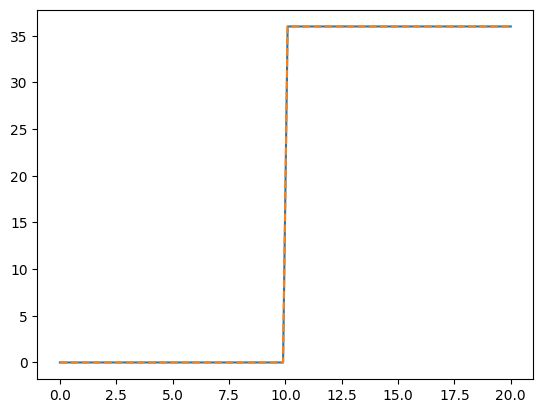

In [8]:
class ESC:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        esc_eff = params['esc_eff']

        # Get the inputs
        esc_D = u[0]
        esc_Vi = u[1]
        esc_Io = u[2]

        # Saturate esc_D
        esc_D = np.clip(esc_D, 0, 1)

        #
        esc_Vo = esc_D * esc_Vi
        esc_Ii = esc_Io * esc_D / esc_eff

        return (esc_Vo, esc_Ii)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="esc",
            states=None,
            inputs=("D", "Vi", "Io"),
            outputs=("Vo", "Ii"),
            params=params,
        )

esc_eff = 0.8

sys = ESC.build({"esc_eff": esc_eff})
display(sys.__dict__)

T = np.linspace(0, 20, 100)
esc_D = np.array(
    [
        [0] * (len(T) // 2),
        [1] * (len(T) // 2),
    ]
).ravel()
esc_Vi = np.ones_like(T) * 36
esc_Io = np.zeros_like(T)
U = [esc_D, esc_Vi, esc_Io]

T, yout = ct.input_output_response(sys, T, U)

plt.plot(T, U[0] * esc_Vi)
plt.plot(T, yout[0], "--")
plt.show()


name,value,initial value,min,max,vary
motor_R,0.03300000,0.033,0.03267000,0.03333000,False
motor_L,1.0000e-03,0.001,9.9000e-04,0.00101000,False
motor_B,0.00410738,0.004107378189919799,0.00406630,0.00414845,False
motor_J,0.03920000,0.039200000000000006,0.03880800,0.03959200,False
motor_J_load,0.00875321,0.0087532083,1.0000e-06,1.00000000,False
motor_K,0.10596697,0.10596697039485706,0.10490730,0.10702664,False
prop_K,0.00162292,0.0016229208372061088,0.00160669,0.00163915,False
prop_D,0.22860000,0.2286,0.22631400,0.23088600,False
rho,1025.00000,1025,1014.75000,1035.25000,False
trans_eff,0.95000000,0.95,0.94050000,0.95950000,False


{'syslist': [<NonlinearIOSystem:propeller:['w']->['Q']>,
  <NonlinearIOSystem:transmission:['wi', 'Qo']->['wo', 'Qi']>,
  <LinearIOSystem:motor:['V', 'Q']->['I', 'w']>,
  <NonlinearIOSystem:esc:['D', 'Vi', 'Io']->['Vo', 'Ii']>],
 'syslist_index': {'propeller': 0, 'transmission': 1, 'motor': 2, 'esc': 3},
 'state_offset': [0, 0, 0, 2],
 'input_offset': [0, 1, 3, 5],
 'output_offset': [0, 1, 3, 5],
 'name': 'propulsion',
 'ninputs': 2,
 'input_index': {'D': 0, 'Vi': 1},
 'noutputs': 2,
 'output_index': {'Ii': 0, 'w': 1},
 'nstates': 2,
 'state_index': {'motor_I': 0, 'motor_w': 1},
 'dt': 0,
 'params': {},
 'connect_map': array([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]]),
 'input_map': array([[0., 0.],
        [0., 0.],
        [0., 0.],
 

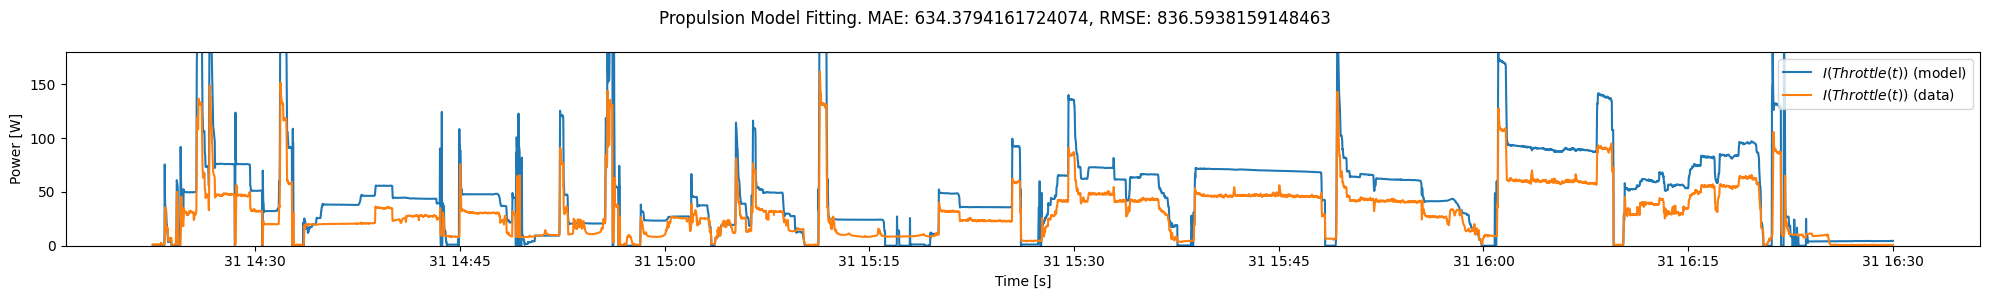

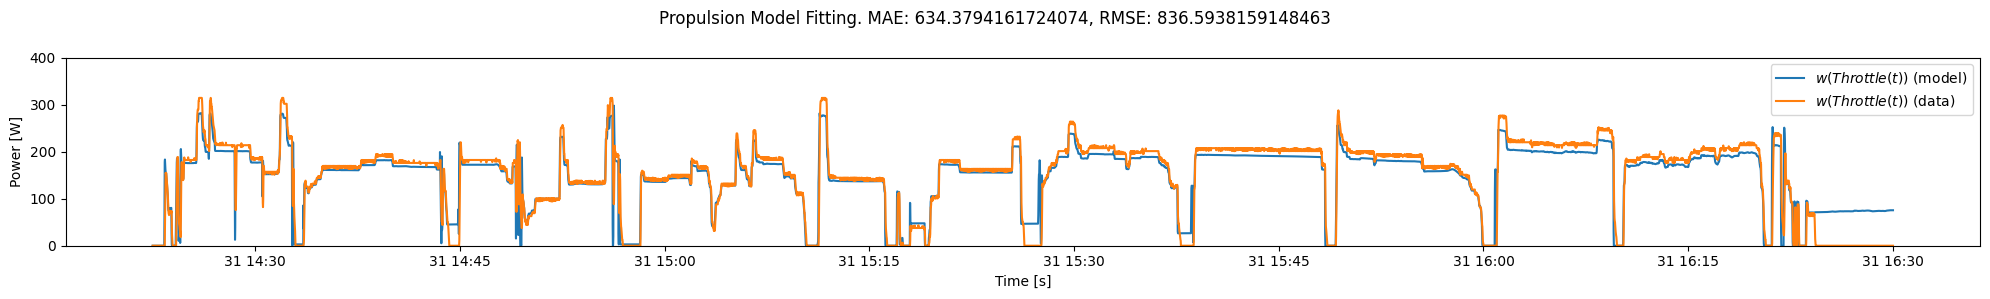

In [9]:
class Propulsion:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            (
                Propeller.build(params),
                Transmission.build(params),
                Motor.build(params),
                ESC.build(params),
            ),
            name="propulsion",
            connections=[
                ["propeller.w", "transmission.wo"], ["transmission.Qo", "propeller.Q"],  # Transmission to Propeller
                ["transmission.wi", "motor.w"], ["motor.Q", "transmission.Qi"],  # Motor to Transmission
                # ["propeller.w", "motor.w"], ["motor.Q", "propeller.Q"], # motor direct to propeller
                ["motor.V", "esc.Vo"], ["esc.Io", "motor.I"],  # ESC to Motor
            ],
            inplist=["esc.D", "esc.Vi"],
            inputs=["D", "Vi"],
            outlist=["esc.Ii", "motor.w"],
            outputs=["Ii", "w"],
        )

# Missing initial Guess
prop_mass = 0.67  # kg
motor_J_load = prop_mass*(prop_D/2)**2

# Parameters
params = lmfit.Parameters()
params.add_many(
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
    ("motor_R", motor_R, False, motor_R*1.01, motor_R*0.99, None, None),  # Motor Armature Resistance [Ω]
    ("motor_L", motor_L, False, motor_L*1.01, motor_L*0.99, None, None),  # Motor Armature Inductance [Henrys]
    ("motor_B", motor_B, False, motor_B*1.01, motor_B*0.99, None, None),  # Motor Mechanical Frictional coeffiecient [Nm/(rad/s)]
    ("motor_J", motor_J, False, motor_J*1.01, motor_J*0.99, None, None),  # Motor Rotor Inertial moment [Kgm²]
    ("motor_J_load", motor_J_load, False, 1e-6, 1, None, None),  # Motor Load Inertial moment [Kgm²]
    ("motor_K", motor_K, False, motor_K*1.01, motor_K*0.99, None, None),  # Volt-revolution ratio [V/(rad/s)]
    ("prop_K", prop_K, False, prop_K*1.01, prop_K*0.99, None, None),  # Propeller torque coefficient
    ("prop_D", prop_D, False, prop_D*1.01, prop_D*0.99, None, None),  # Nominal Propeller diameter (70% of the measured diameter) [m]
    ("rho", rho, False, rho*1.01, rho*0.99, None, None),  # Water density [kg/m3]
    ("trans_eff", trans_eff, False, trans_eff*1.01, trans_eff*0.99, None, None),
    ("esc_eff", esc_eff, False, esc_eff*1.01, esc_eff*0.99, None, None),
    ("trans_K", trans_K, False, trans_K*1.01, trans_K*0.99, None, None), # Transmission's gear ratio as `output speed / input speed`
)
display(params)

# Model
propulsion = Propulsion.build(params.valuesdict())
display(propulsion.__dict__)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
esc_D = df["esc_dt"].to_numpy()
batt_V = df["bat_v"].to_numpy()

if True:
    # Test initial parameters
    df_init = ct.input_output_response(
        propulsion,
        T=T,
        U=[esc_D, batt_V],
        solve_ivp_method="Radau",
    ).to_pandas()

    df['esc_pi'] = df['esc_ii'] * df['bat_v']
    df_init['esc_pi'] = df_init['Ii'].to_numpy() * df_init['Vi'].to_numpy()

    rmse = (((df['esc_pi'].to_numpy() - df_init['esc_pi'].to_numpy())**2).sum() / len(df))**(1/2)
    mae = abs(df['esc_pi'].to_numpy() - df_init['esc_pi'].to_numpy()).sum() / len(df)

    plt.figure(figsize=(20, 3))
    plt.plot(df.index, df_init['Ii'], label='$I(Throttle(t))$ (model)')
    plt.plot(df.index, df['esc_ii'], label='$I(Throttle(t))$ (data)')
    plt.xlabel('Time [s]')
    plt.ylabel('Power [W]')
    plt.legend(loc=1)
    plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
    plt.ylim([0,180])
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 3))
    plt.plot(df.index, df_init['w'], label='$w(Throttle(t))$ (model)')
    plt.plot(df.index, df['motor_w'], label='$w(Throttle(t))$ (data)')
    plt.xlabel('Time [s]')
    plt.ylabel('Power [W]')
    plt.legend(loc=1)
    plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
    plt.ylim([0,400])
    plt.tight_layout()
    plt.show()

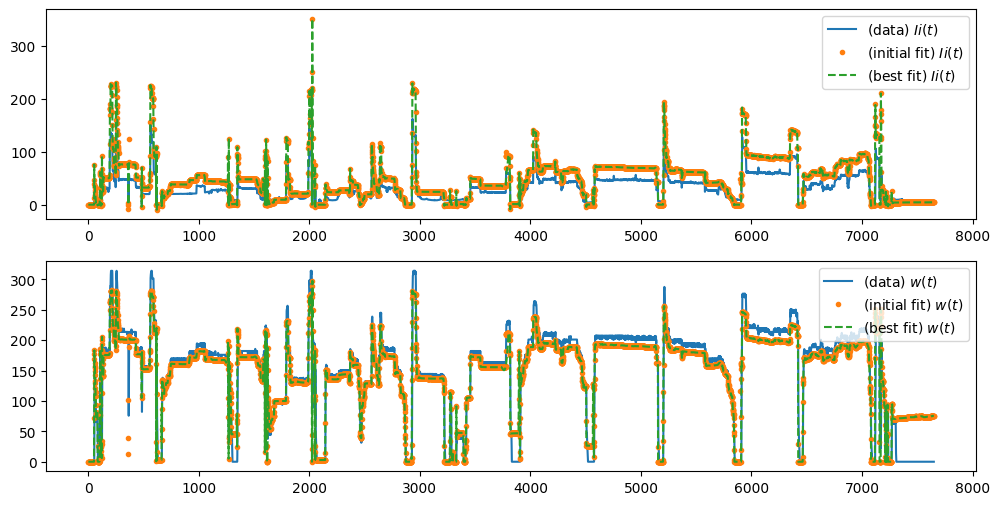

In [20]:
def func(T, U, **params):
    return ct.input_output_response(
        Propulsion.build(params),
        T=T,
        U=U,
        solve_ivp_method="Radau",
    ).outputs.T


model = lmfit.Model(
    func=func,
    independent_vars=["T", "U"],
)

params = lmfit.Parameters()
motor_L_min = 1e-6
motor_L_max = 1e-1
prop_K_max = prop_K*1.5
prop_K_min = prop_K*0.5
params.add_many(
    # Important reading about stiff problems: https://github.com/scipy/scipy/issues/11698
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
    ("motor_R", motor_R, True, motor_R*1.1, motor_R*0.9, None, None),  # Motor Armature Resistance [Ω]
    ("motor_L", motor_L, True, motor_L_max, motor_L_min, None, None),  # Motor Armature Inductance [Henrys]
    ("motor_B", motor_B, True, motor_B*1.1, motor_B*0.9, None, None),  # Motor Mechanical Frictional coeffiecient [Nm/(rad/s)]
    ("motor_J", motor_J, True, motor_J*1.1, motor_J*0.9, None, None),  # Motor Rotor Inertial moment [Kgm²]
    ("motor_J_load", motor_J_load, False, 1e-6, 1, None, None),  # Motor Load Inertial moment [Kgm²]
    ("motor_K", motor_K, False, motor_K*1.1, motor_K*0.9, None, None),  # Volt-revolution ratio [V/(rad/s)]
    ("prop_K", prop_K, True, prop_K_max, prop_K_min, None, None),  # Propeller torque coefficient
    ("prop_D", prop_D, True, prop_D*1.1, prop_D*0.9, None, None),  # Nominal Propeller diameter (70% of the measured diameter) [m]
    ("rho", rho, False, rho*1.1, rho*0.9, None, None),  # Water density [kg/m3]
    ("trans_eff", trans_eff, False, trans_eff*1.1, trans_eff*0.9, None, None),
    ("esc_eff", esc_eff, False, esc_eff*1.1, esc_eff*0.9, None, None),
    ("trans_K", trans_K, False, trans_K*1.1, trans_K*0.9, None, None), # Transmission's gear ratio as `output speed / input speed`
)
# display(params)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs and Fit Data
U = df[["esc_dt", "bat_v"]].to_numpy().T
data = df[["esc_ii", "motor_w"]].copy(deep=True).to_numpy()

result = model.fit(
    data=data,
    params=params,
    T=T,
    U=U,
    method='L-BFGS-B',
    # method='COBYLA',  # this works, takes ~30min
    # method='direct',
    # method="least_squares", # this doesn't work, takes ~6min
    # fit_kws=dict(
    #     jac='3-point',
    #     ftol=1e-8,
    #     xtol=1e-8,
    #     # loss='soft_l1',  # 8min, 25it, reduced chi-square: 113.812658
    #     # loss='huber',  #
    #     loss='cauchy',  # 4min, 13it, reduced chi-square: 116.362934
    #     x_scale='jac',
    #     # diff_step=np.array([
    #     #     1e-04,
    #     #     1e-04,
    #     #     1e-04,
    #     #     1e-04,
    #     #     1e-01,
    #     # ]),
    #     # max_nfev=20,
    # ),
)

fig, ax = plt.subplots(2, figsize=(12, 3*2))
for i, (initial, best, data) in enumerate(
    zip(result.init_fit.T, result.best_fit.T, result.data.T)
):
    label = propulsion.output_labels[i]

    ax[i].plot(data, label=f"(data) ${label}(t)$")
    ax[i].plot(initial, ".", label=f"(initial fit) ${label}(t)$")
    ax[i].plot(best, "--", label=f"(best fit) ${label}(t)$")
    ax[i].legend(loc=1)

plt.show()

result

In [22]:
# LOAD BRUTE RESULTS
result = lmfit.model.load_modelresult('lmfit_models/propulsion.ipynb_brute10000.sav', funcdefs=dict(func=func))
brute_params = result.params.valuesdict()
brute_params

{'motor_R': 0.033,
 'motor_L': 0.001,
 'motor_B': 0.004009440228361086,
 'motor_J': 0.039200000000000006,
 'motor_J_load': 0.01000099,
 'motor_K': 0.10324265711774457,
 'prop_K': 0.001704581018131716,
 'prop_D': 0.21589999999999998,
 'rho': 1025,
 'trans_eff': 0.95,
 'esc_eff': 0.8,
 'trans_K': 0.5909090909090909}

In [23]:
def resid(params, x, ydata=None, eps=None):
    T = x[0]
    esc_D = x[1]
    esc_Vi = x[2]
    W = x[3] if len(x) >= 2 else None   # Weights

    ymodel = ct.input_output_response(
        Propulsion.build(params.valuesdict()),
        T=T,
        U=[esc_D, esc_Vi],
        X0=[0, 0],
        solve_ivp_method='Radau',
    ).outputs.T

    if ydata is None:
        return ymodel

    res = ydata - ymodel

    # Apply weights
    if W is not None:
        res = res * W

    res = res.flatten()

    if eps is None:
        return res

    return res / eps

# Use parameters from brute
params = lmfit.Parameters()
motor_R = brute_params['motor_R']
motor_L = brute_params['motor_L']
motor_B = brute_params['motor_B']
motor_J = brute_params['motor_J']
motor_J_load = brute_params['motor_J_load']
motor_K = brute_params['motor_K']
prop_K = brute_params['prop_K']
prop_D = brute_params['prop_D']
rho = brute_params['rho']
trans_eff = brute_params['trans_eff']
esc_eff = brute_params['esc_eff']
trans_K = brute_params['trans_K']
params.add_many(
    # Important reading about stiff problems: https://github.com/scipy/scipy/issues/11698
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
    ("motor_R", motor_R, False, motor_R*1.1, motor_R*0.9, None, None),  # Motor Armature Resistance [Ω]
    ("motor_L", motor_L, False, motor_L*1.1, motor_L*0.9, None, None),  # Motor Armature Inductance [Henrys]
    ("motor_B", motor_B, False, motor_B*1.1, motor_B*0.9, None, None),  # Motor Mechanical Frictional coeffiecient [Nm/(rad/s)]
    ("motor_J", motor_J, False, motor_J*1.1, motor_J*0.9, None, None),  # Motor Rotor Inertial moment [Kgm²]
    ("motor_J_load", motor_J_load, True, 1e-6, 1, None, None),  # Motor Load Inertial moment [Kgm²]
    ("motor_K", motor_K, False, motor_K*1.1, motor_K*0.9, None, None),  # Volt-revolution ratio [V/(rad/s)]
    ("prop_K", prop_K, True, prop_K*1.1, prop_K*0.9, None, None),  # Propeller torque coefficient
    ("prop_D", prop_D, False, prop_D*1.1, prop_D*0.9, None, None),  # Nominal Propeller diameter (70% of the measured diameter) [m]
    ("rho", rho, False, rho*1.1, rho*0.9, None, None),  # Water density [kg/m3]
    ("trans_eff", trans_eff, False, trans_eff*1.1, trans_eff*0.9, None, None),
    ("esc_eff", esc_eff, False, esc_eff*1.1, esc_eff*0.9, None, None),
    ("trans_K", trans_K, False, trans_K*1.1, trans_K*0.9, None, None), # Transmission's gear ratio as `output speed / input speed`
)
# display(params)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs and Fit Data
esc_D = df["esc_dt"].to_numpy()
batt_V = df["bat_v"].to_numpy()
data = df[["esc_ii", "motor_w"]].copy(deep=True).to_numpy()

# Fit weights
W_I = esc_D + 1
W_I = W_I / W_I.max()
W_w = np.ones_like(W_I)#*0.5
W_I = W_w
W = np.array([W_I, W_w]).T

result = lmfit.minimize(
    resid,
    params,
    args=([T, esc_D, batt_V, W], data),
    # method="least_squares",
    # scale_covar=True,
    # **dict(
        # jac='3-point',
        # ftol=1e-12,
        # xtol=1e-12,
        # loss='soft_l1',  # 8min, 25it, reduced chi-square: 113.812658
        # loss='huber',  #
        # loss='cauchy',  # 4min, 13it, reduced chi-square: 116.362934
        # x_scale='jac',
        # diff_step=np.array([
        #     1e-04,
        #     1e-04,
        #     1e-04,
        #     1e-04,
        #     1e-01,
        # ]),
        # max_nfev=20,
    # )
    method="differential_evolution",  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
    **dict(
    #     updating="deferred",
    #     disp=True,
    #     polish=True,
        workers=4,
    #     max_nfev=100_000,
    #     seed=1,
    #     # strategy="currenttobest1bin",
    #     strategy="randtobest1bin",
    ),
    # method='SLSQP', #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_slsqp.html
)

result


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [24]:
df_init = ct.input_output_response(
    Propulsion.build(params.valuesdict()),
    T=T,
    U=[esc_D, batt_V],
    solve_ivp_kwargs={"method": "Radau"},
).to_pandas()[["Ii", "w"]]

df_best = ct.input_output_response(
    Propulsion.build(result.params.valuesdict()),
    T=T,
    U=[esc_D, batt_V],
    solve_ivp_kwargs={"method": "Radau"},
).to_pandas()[["Ii", "w"]]


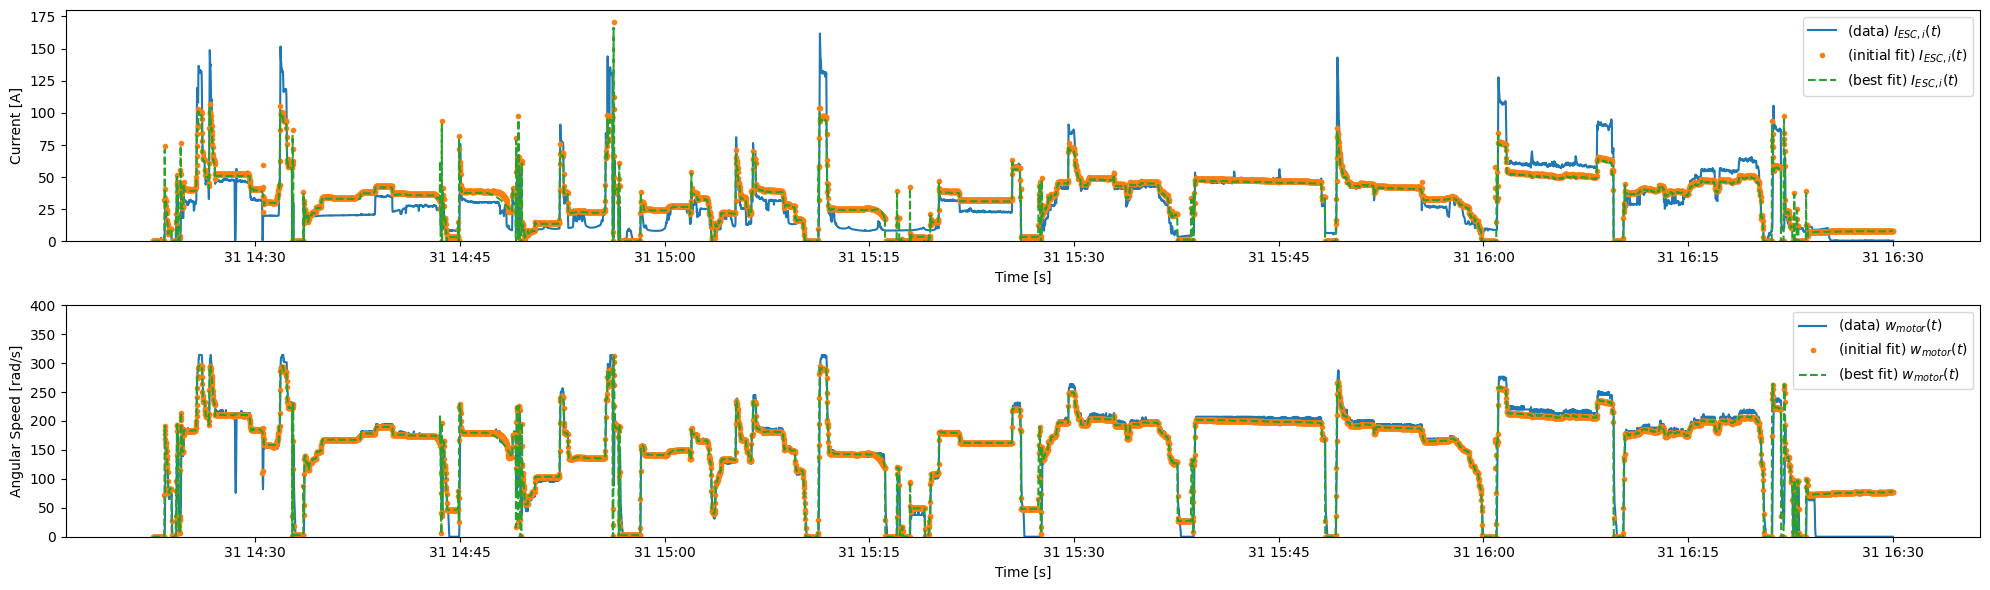

In [25]:
fig, ax = plt.subplots(2, figsize=(20, 3 * 2))

ax[0].plot(df.index, df["esc_ii"], label="(data) $I_{ESC,i}(t)$")
ax[0].plot(df.index, df_init["Ii"], ".", label="(initial fit) $I_{ESC,i}(t)$")
ax[0].plot(df.index, df_best["Ii"], "--", label="(best fit) $I_{ESC,i}(t)$")
ax[0].set_ylim((df["esc_ii"].min()*1.1, df["esc_ii"].max()*1.1))
ax[0].set_ylim([0,180])
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Current [A]')
ax[0].legend(loc=1)

ax[1].plot(df.index, df["motor_w"], label="(data) $w_{motor}(t)$")
ax[1].plot(df.index, df_init["w"], ".", label="(initial fit) $w_{motor}(t)$")
ax[1].plot(df.index, df_best["w"], "--", label="(best fit) $w_{motor}(t)$")
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Angular Speed [rad/s]')
ax[1].set_ylim([0,400])
ax[1].legend(loc=1)

plt.tight_layout()
plt.show()

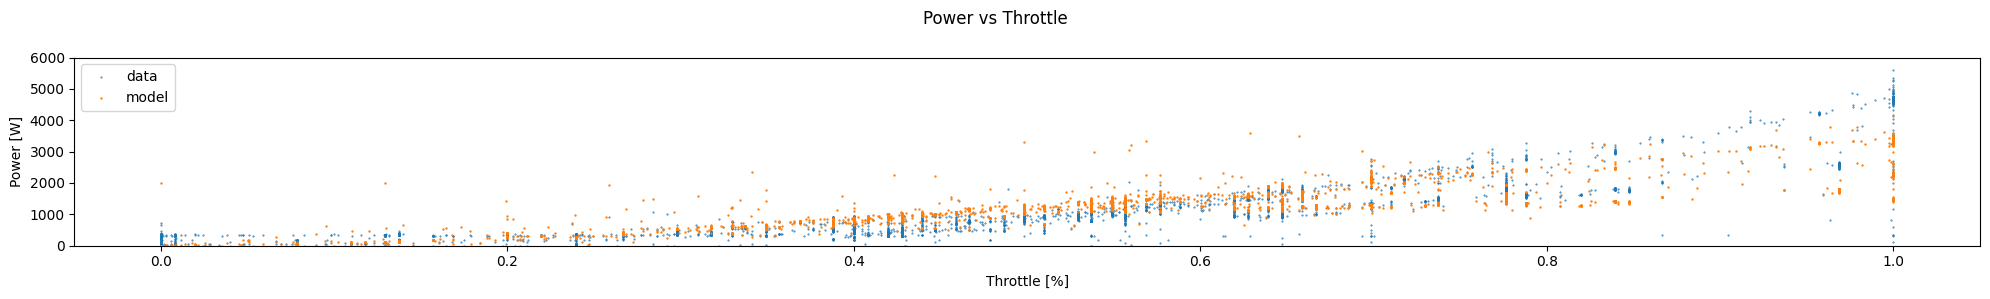

[]

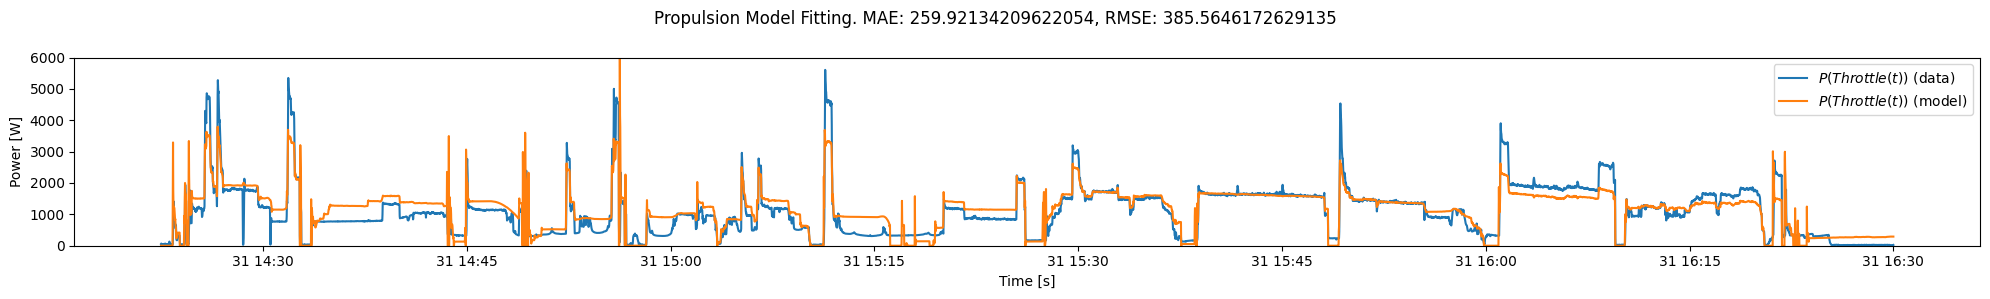

In [26]:
df_best['Ii'] = np.clip(df_best['Ii'].to_numpy(), 0, 200)

df['esc_pi'] = df['esc_ii'] * df['bat_v']
df_best['esc_pi'] = df_best['Ii'].to_numpy() * df['bat_v'].to_numpy()

rmse = (((df['esc_pi'].to_numpy() - df_best['esc_pi'].to_numpy())**2).sum() / len(df))**(1/2)
mae = abs(df['esc_pi'].to_numpy() - df_best['esc_pi'].to_numpy()).sum() / len(df)

plt.figure(figsize=(20,3))
plt.scatter(df['esc_dt'], df['esc_pi'], label='data', s=0.2)
plt.scatter(df['esc_dt'], df_best['esc_pi'], label='model', s=0.5)
plt.xlabel('Throttle [%]')
plt.ylabel('Power [W]')
plt.legend(loc=0)
plt.suptitle('Power vs Throttle')
plt.ylim([0,6000])
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(df.index, df['esc_pi'], label='$P(Throttle(t))$ (data)')
plt.plot(df.index, df_best['esc_pi'], label='$P(Throttle(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.ylim([0,6000])
plt.tight_layout()
plt.plot()